## Bibliotecas e dados

In [113]:
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pmdarima as pm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#mpl.rcParams['figure.figsize'] = [10, 5]

ModuleNotFoundError: No module named 'pmdarima'

In [26]:
#df = pd.read_csv("chuva_fortaleza.csv")
#df.set_index(df['Year'], inplace=True) 
#df = df.drop('Year', 1)
#df = df['Milimitros']
#df.plot()
#df.head()

,Year,Milimitros
0,1850,852
1,1851,1806
2,1852,1356
3,1853,1233
4,1854,1590


In [90]:
df = pd.read_csv("temp_dehli.csv")

In [91]:
df = df[["date", "meantemp"]]
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.set_index(df['date'], inplace=True) 
df = df.drop('date', 1)
# df = df['meantemp']


C:\Users\mcso\AppData\Local\Temp/ipykernel_10676/3726606635.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('date', 1)


In [92]:
df.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


## Plot

<AxesSubplot:xlabel='date'>

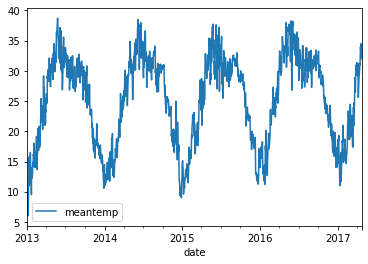

In [93]:
df.plot()

## Decomposição

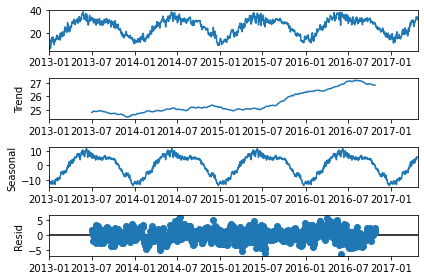

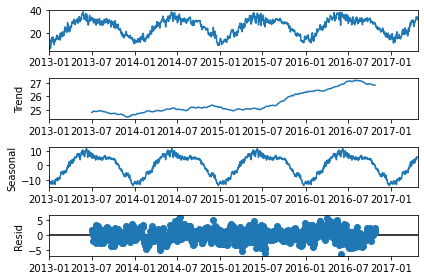

In [94]:
df_decomp = tsa.seasonal_decompose(df, period=365)
df_decomp.plot()

## Estacionariedade

In [95]:
test, pvalue, lags, obs, critic, ic = tsa.stattools.adfuller(df, regression='ct')
print(pvalue)
print(lags)

0.3993675522472093
10


## Diferenciação

<AxesSubplot:xlabel='date'>

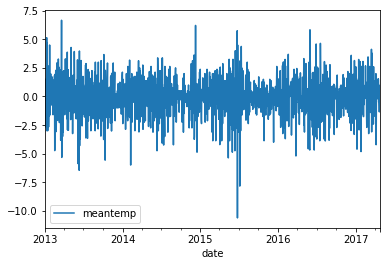

In [96]:
df.diff().plot()

<AxesSubplot:ylabel='Frequency'>

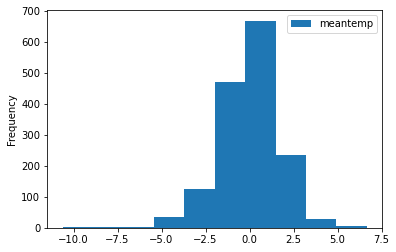

In [97]:
df.diff().plot.hist()

In [98]:
dfd1 = df.diff().dropna()

In [99]:
test, pvalue, lags, obs, critic, ic = tsa.stattools.adfuller(dfd1, regression='ct')
print(pvalue)
print(lags)

0.0
9


## Autocorrelação

### Correlação

In [100]:
df.corrwith(df.shift(1))

meantemp    0.974134
dtype: float64

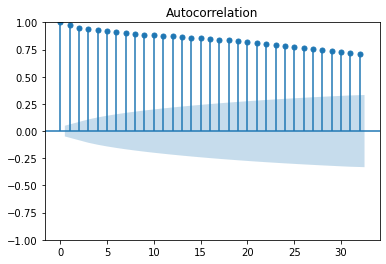

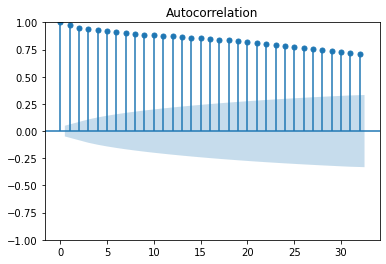

In [101]:
plot_acf(df)

Correlação com série diferenciada

In [103]:
dfd1.corrwith(dfd1.shift(1))

meantemp   -0.156369
dtype: float64

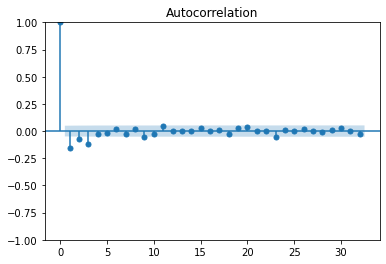

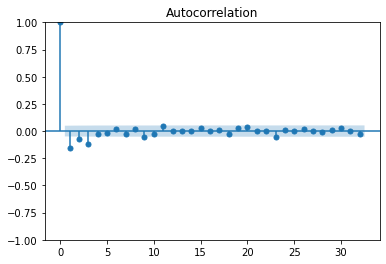

In [102]:
plot_acf(dfd1)

## Autocorrelação Parcial

C:\Users\mcso\anaconda3\envs\data_science\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


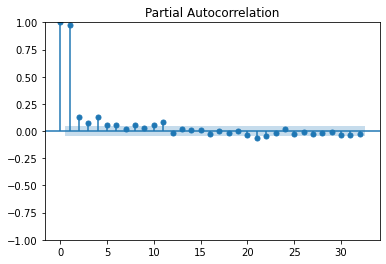

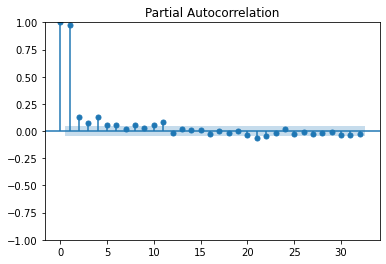

In [104]:
plot_pacf(df)

Correlação Parcial com série diferenciada

C:\Users\mcso\anaconda3\envs\data_science\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


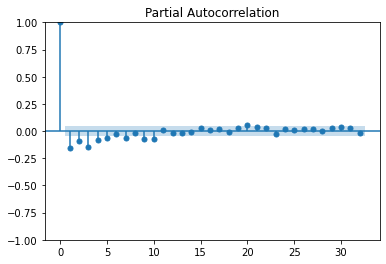

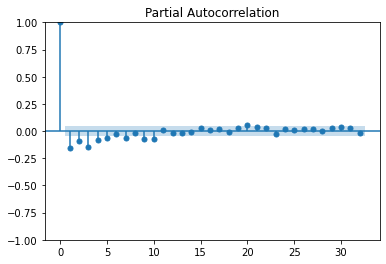

In [105]:
plot_pacf(dfd1)

## Separando dados

In [107]:
df_train = df.iloc[:int(len(df) * 0.75)]
df_test = df.iloc[int(len(df) * 0.75):]

df_train2 = df.iloc[:int(len(df) * 0.5)]
df_valid2 = df.iloc[int(len(df) * 0.5):int(len(df) * 0.75)]
df_test2 = df.iloc[int(len(df) * 0.75):]

### ARIMA

In [ ]:
elnino_arima = pm.auto_arima(elnino, max_ar=10, max_ma=5, max_d=2, seasonal=False, trace=True, stepwise=True)